In [1]:
import leo_satellites as sat
import network_implementation as net_utils
import networkx as nx
import pandas as pd
import numpy as np
import sys
import copy
import scipy.io as sio
from statsmodels.distributions.empirical_distribution import ECDF
import random
import math
import matplotlib.pyplot as plt
from astropy import constants as const
import os
from IPython.display import clear_output
from datetime import datetime
from multiprocessing import Pool
import scipy
import geometry_functions as geom
from matplotlib import font_manager
import matplotlib
import time

In [2]:
R_earth = const.R_earth.value

In [3]:
light_speed = const.c.value

In [4]:
NUMBER_OF_NODES = sat.SATELLITES_PER_ORBIT * sat.NUMBER_OF_ORBITS
NUMBER_OF_ORBITS = sat.NUMBER_OF_ORBITS
SATELLITES_PER_ORBIT = sat.SATELLITES_PER_ORBIT
NUMBER_OF_LEVELS_list = [1,2,3,4,5]
MAX_HOPS = sys.float_info.max
ALTITUDE = 550
EARTH_RADIUS = const.R_earth.value / 1000
MAX_DISTANCE_BETWEEN_SATS = 2*math.sqrt((ALTITUDE**2+2*EARTH_RADIUS*ALTITUDE))
MAX_NUM_LASER_LINK = 5

In [5]:
#graph = sat.create_full_mesh()
OBSERVATION_DATE = '2022/03/30 08:00:00'
ori_graph = sat.create_spaceX_graph(OBSERVATION_DATE)
spaceX_constellation = sat.constellationFromSaVi()
spaceX_positions = sat.positionsAtTime(spaceX_constellation, OBSERVATION_DATE)
distances = sat.distances_pathLabel(spaceX_positions)
graph = ori_graph


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
spaceX_positions_global_idx = np.zeros((NUMBER_OF_NODES,2))
for idx_orbit, orbit in enumerate(spaceX_positions):
    for idx_sat, satellite in enumerate(orbit):
        idx_global = sat.get_node_number(idx_orbit,idx_sat)
        spaceX_positions_global_idx[idx_global,:] = list(satellite)

In [7]:
number_of_landmarks_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

#### Test one number_of_landmarks

In [8]:
number_of_landmarks = 10

In [9]:
landmarkSet = random.sample(range(0, graph.number_of_nodes()), number_of_landmarks)

In [10]:
pathSet = {}
for landmark in landmarkSet:
    paths = nx.algorithms.shortest_path(graph, landmark)
    del paths[landmark]
    pathSet[landmark] = paths

In [11]:
for node in graph.nodes():
    graph.nodes[node]['paths'] = {}
    for landmark in landmarkSet:
        if node != landmark:
            graph.nodes()[node]['paths'][landmark] = pathSet[landmark][node]

In [12]:
pathLenTotal = 0
numPaths = 0
pathLenFreq = {}

#add a destination node to a node's cluster if the path to the destination is shorter than to any landmark node
for nodeId in graph.nodes:
    node = graph.nodes[nodeId]
    cluster = {}
    paths = nx.algorithms.shortest_paths.shortest_path(graph, nodeId)

    #find the closest landmark
    if nodeId == landmarkSet[0]:
        minLandmark = landmarkSet[1]
    else:
        minLandmark = landmarkSet[0]
    minDist = len(node['paths'][minLandmark])
    for landmark in landmarkSet:
        if nodeId != landmark:
            if len(node['paths'][landmark]) < minDist:
                minLandmark = landmark
                minDist = len(node['paths'][landmark])

    #if the path to the node is shorter through another node than a landmark, add the node to the other node's cluster
    for destinationId in graph.nodes:
        if nodeId != destinationId:

            pathLenTotal = pathLenTotal + len(paths[destinationId])
            numPaths = numPaths + 1
            if len(paths[destinationId]) not in pathLenFreq.keys():
                pathLenFreq[len(paths[destinationId])] = 1
            else:
                pathLenFreq[len(paths[destinationId])] = pathLenFreq[len(paths[destinationId])] + 1

            if len(paths[destinationId]) < minDist:
                destination = graph.nodes[destinationId]
                try:
                    destination['cluster'][nodeId] = paths[destinationId][-2]
                except:
                    destination['cluster'] = {}
                    destination['cluster'][nodeId] = paths[destinationId][-2]
    graph.nodes[nodeId]['cluster'] = cluster

In [13]:
#check that all clusters are under the size limit of 4 * sqrt(n log n)
violations = 0
n = graph.number_of_nodes()
limit = 4*math.sqrt(n * math.log(n))

total_cluster_size = 0
for nodeId in graph.nodes:
    total_cluster_size = total_cluster_size + len(graph.nodes()[nodeId]['cluster'])
    if len(graph.nodes[nodeId]['cluster']) > limit:
        violations = violations + 1

# if not os.path.exists('./results/stage3'):
#     os.makedirs('./results/stage3')

# pathFile = open('results/stage3/path-data-' + sys.argv[1] + '.dat', 'w+')
# pathFile.write('average path length: ' + str(round(float(pathLenTotal) / float(numPaths), 2)) + '\n')
# averageCSize = round(float(total_cluster_size) / float(graph.number_of_nodes()))
# pathFile.write('average cluster size: ' + str(averageCSize) + '\n')
# for length in pathLenFreq.keys():
#     pathFile.write(str(length) + ': ' + str(pathLenFreq[length]) + '\n')
# pathFile.close()

# saveFile = open('results/stage3/cluster-' + sys.argv[1] + '.dat', 'w+')
# saveFile.write('violations: ' + str(violations) + '\n')

# for nodeId in graph.nodes:
#     node = graph.nodes[nodeId]
#     output = (nodeId + ': ')

#     for destId in node['cluster'].keys():
#         output = output + '[' + destId + ', ' + node['cluster'][destId] + '], '
#     saveFile.write(output + '\n')
# saveFile.close()

#### Calculate Path Stretch

In [14]:
n = int(graph.number_of_nodes() / 10) + 1
chosenNodes = {}

while len(chosenNodes.keys()) < n:
    node = random.randint(0, graph.number_of_nodes())
    if node not in chosenNodes.keys():
        chosenNodes[node] = {}

In [15]:
#for each chosen node calculate landmark paths and set closest landmark
for nodeId in list(graph.nodes().keys()):
    paths = nx.algorithms.shortest_path(graph, nodeId)

    minLandmark = ''
    if nodeId == landmarkSet[0]:
        minLandmark = landmarkSet[1]
    else:
        minLandmark = landmarkSet[0]
    landmarkPath = paths[minLandmark]

    for landmark in landmarkSet:
        if len(paths[landmark]) < len(landmarkPath):
            minLandmark = landmark
            landmarkPath = paths[landmark]

    graph.nodes()[nodeId]['closestLandmark'] = [minLandmark, landmarkPath]

In [16]:
totalPathStretch = 0.0
totalPaths = 0

#for each chosen node calculate shortest paths
for nodeId in chosenNodes.keys():
    paths = nx.algorithms.shortest_path(graph, nodeId)
    #start by finding the path to the destination's closest landmark

    for destinationId in graph.nodes():
        if nodeId != destinationId:
            destination = graph.nodes()[destinationId]
            destinationLandmark = graph.nodes()[destinationId]['closestLandmark'][0]
            pathToLandmark = paths[destinationLandmark]
            clusterFound = False
            pathLength = 0
            #check if any nodes on the path to the landmark have the destination in their cluster
            for hop in pathToLandmark:
                if destinationId in graph.nodes()[hop]['cluster'].keys():

                    clusterFound = True
                    pathLength = pathToLandmark.index(hop)
                    pathFromClusterNode = nx.shortest_path(graph, hop, destinationId)
                    pathLength = pathLength + len(pathFromClusterNode)

                    pathStretch = 100/float(len(paths[destinationId])) * float(pathLength)
                    shortestPath = paths[destinationId]
                    totalPathStretch = totalPathStretch + pathStretch
                    totalPaths = totalPaths + 1

                    break

            #if no cluster shortcut is found, use the shortest path
            if not clusterFound:
                pathLength = len(pathToLandmark) + len(graph.nodes()[destinationId]['closestLandmark'][1]) -1

                pathStretch = (100/float(len(paths[destinationId]))) * float(pathLength)
                totalPathStretch = totalPathStretch + pathStretch
                totalPaths = totalPaths + 1

print(round((float(totalPathStretch) / float(totalPaths)) /100, 2))

1.36


#### Test a set of Numer_of_landmarks

#### Hop count approach

In [17]:
stretch_list = []
for number_of_landmarks in number_of_landmarks_list:
    print('Now Working On number_of_landmarks = ' + str(number_of_landmarks))
    
    graph = sat.create_spaceX_graph(OBSERVATION_DATE)
    
    landmarkSet = random.sample(range(0, graph.number_of_nodes()), number_of_landmarks)
    
    pathSet = {}
    for landmark in landmarkSet:
        paths = nx.algorithms.shortest_path(graph, landmark)
        del paths[landmark]
        pathSet[landmark] = paths
        
    for node in graph.nodes():
        graph.nodes[node]['paths'] = {}
        for landmark in landmarkSet:
            if node != landmark:
                graph.nodes()[node]['paths'][landmark] = pathSet[landmark][node]
    
    pathLenTotal = 0
    numPaths = 0
    pathLenFreq = {}

    #add a destination node to a node's cluster if the path to the destination is shorter than to any landmark node
    for nodeId in graph.nodes:
        node = graph.nodes[nodeId]
        cluster = {}
        paths = nx.algorithms.shortest_paths.shortest_path(graph, nodeId)

        #find the closest landmark
        if nodeId == landmarkSet[0]:
            minLandmark = landmarkSet[1]
        else:
            minLandmark = landmarkSet[0]
        minDist = len(node['paths'][minLandmark])
        for landmark in landmarkSet:
            if nodeId != landmark:
                if len(node['paths'][landmark]) < minDist:
                    minLandmark = landmark
                    minDist = len(node['paths'][landmark])

        #if the path to the node is shorter through another node than a landmark, add the node to the other node's cluster
        for destinationId in graph.nodes:
            if nodeId != destinationId:

                pathLenTotal = pathLenTotal + len(paths[destinationId])
                numPaths = numPaths + 1
                if len(paths[destinationId]) not in pathLenFreq.keys():
                    pathLenFreq[len(paths[destinationId])] = 1
                else:
                    pathLenFreq[len(paths[destinationId])] = pathLenFreq[len(paths[destinationId])] + 1

                if len(paths[destinationId]) < minDist:
                    destination = graph.nodes[destinationId]
                    try:
                        destination['cluster'][nodeId] = paths[destinationId][-2]
                    except:
                        destination['cluster'] = {}
                        destination['cluster'][nodeId] = paths[destinationId][-2]
        graph.nodes[nodeId]['cluster'] = cluster

    n = int(graph.number_of_nodes() / 10) + 1
    chosenNodes = {}

    while len(chosenNodes.keys()) < n:
        node = random.randint(0, graph.number_of_nodes()-1)
        if node not in chosenNodes.keys():
            chosenNodes[node] = {}

    #for each chosen node calculate landmark paths and set closest landmark
    for nodeId in list(graph.nodes().keys()):
        paths = nx.algorithms.shortest_path(graph, nodeId)

        minLandmark = ''
        if nodeId == landmarkSet[0]:
            minLandmark = landmarkSet[1]
        else:
            minLandmark = landmarkSet[0]
        landmarkPath = paths[minLandmark]

        for landmark in landmarkSet:
            if len(paths[landmark]) < len(landmarkPath):
                minLandmark = landmark
                landmarkPath = paths[landmark]

        graph.nodes()[nodeId]['closestLandmark'] = [minLandmark, landmarkPath]
        
    totalPathStretch = 0.0
    totalPaths = 0

    #for each chosen node calculate shortest paths
    for nodeId in chosenNodes.keys():
        paths = nx.algorithms.shortest_path(graph, nodeId)
        #start by finding the path to the destination's closest landmark

        for destinationId in graph.nodes():
            if nodeId != destinationId:
                destination = graph.nodes()[destinationId]
                destinationLandmark = graph.nodes()[destinationId]['closestLandmark'][0]
                pathToLandmark = paths[destinationLandmark]
                clusterFound = False
                pathLength = 0
                #check if any nodes on the path to the landmark have the destination in their cluster
                for hop in pathToLandmark:
                    if destinationId in graph.nodes()[hop]['cluster'].keys():

                        clusterFound = True
                        pathLength = pathToLandmark.index(hop)
                        pathFromClusterNode = nx.shortest_path(graph, hop, destinationId)
                        pathLength = pathLength + len(pathFromClusterNode)

                        pathStretch = 100/float(len(paths[destinationId])) * float(pathLength)
                        shortestPath = paths[destinationId]
                        totalPathStretch = totalPathStretch + pathStretch
                        totalPaths = totalPaths + 1

                        break

                #if no cluster shortcut is found, use the shortest path
                if not clusterFound:
                    pathLength = len(pathToLandmark) + len(graph.nodes()[destinationId]['closestLandmark'][1]) -1

                    pathStretch = (100/float(len(paths[destinationId]))) * float(pathLength)
                    totalPathStretch = totalPathStretch + pathStretch
                    totalPaths = totalPaths + 1

    print('Stretch when number_of_landmarks = ' + str(number_of_landmarks))
    stretch_list.append(round((float(totalPathStretch) / float(totalPaths)) /100, 4))
    print(round((float(totalPathStretch) / float(totalPaths)) /100, 4))            

Now Working On number_of_landmarks = 10
Stretch when number_of_landmarks = 10
1.3655
Now Working On number_of_landmarks = 20
Stretch when number_of_landmarks = 20
1.2949
Now Working On number_of_landmarks = 30
Stretch when number_of_landmarks = 30
1.271
Now Working On number_of_landmarks = 40
Stretch when number_of_landmarks = 40
1.2519
Now Working On number_of_landmarks = 50
Stretch when number_of_landmarks = 50
1.2349
Now Working On number_of_landmarks = 60
Stretch when number_of_landmarks = 60
1.2189
Now Working On number_of_landmarks = 70
Stretch when number_of_landmarks = 70
1.2097
Now Working On number_of_landmarks = 80
Stretch when number_of_landmarks = 80
1.2041
Now Working On number_of_landmarks = 90
Stretch when number_of_landmarks = 90
1.191
Now Working On number_of_landmarks = 100
Stretch when number_of_landmarks = 100
1.1852


#### pathlength approach

In [18]:
#get shortest paths of all nodes
all_paths = []
for nodeId in ori_graph.nodes():
    all_paths.append(nx.algorithms.shortest_path(ori_graph, source = nodeId, weight =  'weight'))
    print('Finished node ' + str(nodeId))
    clear_output(wait=True)

Finished node 1583


In [19]:
#backup_all_paths = copy.deepcopy(all_paths)

In [20]:
#get shortest pathlength of all nodes
all_paths_length = np.zeros((ori_graph.number_of_nodes(),ori_graph.number_of_nodes()))
for nodeId in ori_graph.nodes():
    cur_pathlength = nx.algorithms.shortest_path_length(ori_graph, source = nodeId, weight =  'weight')
    cur_pathlength_list = np.zeros((ori_graph.number_of_nodes()))
    for key, value in cur_pathlength.items():
        all_paths[nodeId].update({key:[all_paths[nodeId][key], value]})
        cur_pathlength_list[key] = value
    all_paths_length[nodeId,:] = cur_pathlength_list
    print('Finished node ' + str(nodeId))
    clear_output(wait=True)

Finished node 1583


In [21]:
landmarkSets = []
landmarkSet = random.sample(range(0, ori_graph.number_of_nodes()), number_of_landmarks_list[0])
landmarkSets.append(copy.deepcopy(landmarkSet))
for i in range(1, len(number_of_landmarks_list)):
    while len(landmarkSet) < number_of_landmarks_list[i]:
        landmark = np.random.randint(ori_graph.number_of_nodes()) 
        if landmark not in landmarkSet:
            landmarkSet.append(landmark)
    landmarkSets.append(copy.deepcopy(landmarkSet))

In [22]:
#Pick Test Nodes
n = int(ori_graph.number_of_nodes() / 10) + 1
chosenNodes = random.sample(range(ori_graph.number_of_nodes()), n)     

In [23]:
stretch_list = []      
stretch_all = []
routing_table_size = []
rtt_cost = []
for landmarkSet in landmarkSets:
    print('Now Working On number_of_landmarks = ' + str(len(landmarkSet)))
    
    graph = copy.deepcopy(ori_graph)
    
    pathSet = {}
    for landmark in landmarkSet:
        paths = copy.deepcopy(all_paths[landmark])
        del paths[landmark]
        pathSet[landmark] = paths
        
    for nodeId in graph.nodes():
        graph.nodes[nodeId]['paths'] = {}
        for landmark in landmarkSet:
            if nodeId != landmark:
                graph.nodes()[nodeId]['paths'][landmark] = pathSet[landmark][nodeId]

    #add a destination node to a node's cluster if the path to the destination is shorter than to any landmark node
    for nodeId in graph.nodes:
        graph.nodes[nodeId]['cluster'] = []
        
    for nodeId in graph.nodes:
        node = graph.nodes[nodeId]
        paths = copy.deepcopy(all_paths[nodeId])

        #find the closest landmark
        if nodeId == landmarkSet[0]:
            minLandmark = landmarkSet[1]
        else:
            minLandmark = landmarkSet[0]
        minDist = node['paths'][minLandmark][1]
        for landmark in landmarkSet:
            if nodeId != landmark:
                if node['paths'][landmark][1] < minDist:
                    minLandmark = landmark
                    minDist = node['paths'][landmark][1]

        #if the path to the node is shorter through another node than a landmark, add the node to the other node's cluster
        for destinationId in graph.nodes:
            if nodeId != destinationId:
                if paths[destinationId][1] < minDist or np.floor(nodeId/SATELLITES_PER_ORBIT) == np.floor(destinationId/SATELLITES_PER_ORBIT):
                    graph.nodes[destinationId]['cluster'].append(nodeId)
    
    #calculate routing_table_size
    cur_routing_table_size = []
    for nodeId in graph.nodes():
        routing_table = list(set(graph.nodes[nodeId]['cluster'] + landmarkSet))
        cur_routing_table_size.append(len(routing_table))
    routing_table_size.append(cur_routing_table_size)
    
    print('average_routing_table_size = ' + str(np.sum(cur_routing_table_size)/NUMBER_OF_NODES))
    
    #for each chosen node calculate landmark paths and set closest landmark
    for nodeId in graph.nodes():
        paths = copy.deepcopy(all_paths[nodeId])

        minLandmark = ''
        if nodeId == landmarkSet[0]:
            minLandmark = landmarkSet[1]
        else:
            minLandmark = landmarkSet[0]
        landmarkPath = paths[minLandmark]

        for landmark in landmarkSet:
            if paths[landmark][1] < landmarkPath[1]:
                minLandmark = landmark
                landmarkPath = paths[landmark]

        graph.nodes()[nodeId]['closestLandmark'] = [minLandmark, landmarkPath]
        
    totalPathStretch = 0.0
    pathstretch_record = []
    totalPaths = 0

    #for each chosen node calculate shortest paths
    cur_rtt_cost = []
    for nodeId in chosenNodes:
        paths = copy.deepcopy(all_paths[nodeId])
        #start by finding the path to the destination's closest landmark

        for destinationId in graph.nodes():
            if nodeId != destinationId:
                destination = graph.nodes()[destinationId]
                destinationLandmark = graph.nodes()[destinationId]['closestLandmark'][0]
                pathToLandmark = paths[destinationLandmark]
                clusterFound = False
                pathLength = 0
                #check if any nodes on the path to the landmark have the destination in their cluster
                for hop in pathToLandmark[0]:
                    if destinationId in graph.nodes()[hop]['cluster']:

                        clusterFound = True
                        pathLength = paths[hop][1]
                        pathFromClusterNode = all_paths[hop][destinationId][1]
                        pathLength = pathLength + pathFromClusterNode

                        pathStretch = pathLength/paths[destinationId][1]
                        pathstretch_record.append(pathStretch)
                        cur_rtt_cost.append((pathLength - paths[destinationId][1])*2*1000/light_speed)
                        shortestPath = paths[destinationId][0]
                        totalPathStretch = totalPathStretch + pathStretch
                        totalPaths = totalPaths + 1

                        break

                #if no cluster shortcut is found, use the shortest path
                if not clusterFound:
                    pathLength = pathToLandmark[1] + graph.nodes()[destinationId]['closestLandmark'][1][1]

                    pathStretch = pathLength/paths[destinationId][1]
                    pathstretch_record.append(pathStretch)
                    cur_rtt_cost.append((pathLength - paths[destinationId][1])*2*1000/light_speed)
                    totalPathStretch = totalPathStretch + pathStretch
                    totalPaths = totalPaths + 1

    print('Stretch when number_of_landmarks = ' + str(len(landmarkSet)))
    stretch_list.append(round(totalPathStretch / totalPaths, 4))
    stretch_all.append(pathstretch_record)
    rtt_cost.append(cur_rtt_cost)
    print(round(totalPathStretch / totalPaths, 4))      

Now Working On number_of_landmarks = 10
average_routing_table_size = 153.56313131313132
Stretch when number_of_landmarks = 10
1.1209
Now Working On number_of_landmarks = 20
average_routing_table_size = 120.33333333333333
Stretch when number_of_landmarks = 20
1.0993
Now Working On number_of_landmarks = 30
average_routing_table_size = 105.10732323232324
Stretch when number_of_landmarks = 30
1.0888
Now Working On number_of_landmarks = 40
average_routing_table_size = 95.64520202020202
Stretch when number_of_landmarks = 40
1.0772
Now Working On number_of_landmarks = 50
average_routing_table_size = 100.57638888888889
Stretch when number_of_landmarks = 50
1.0711
Now Working On number_of_landmarks = 60
average_routing_table_size = 104.64078282828282
Stretch when number_of_landmarks = 60
1.0656
Now Working On number_of_landmarks = 70
average_routing_table_size = 110.08459595959596
Stretch when number_of_landmarks = 70
1.0605
Now Working On number_of_landmarks = 80
average_routing_table_size = 1

In [24]:
stretch_all = np.array(stretch_all)
routing_table_size = np.array(routing_table_size)
rtt_cost = np.array(rtt_cost)

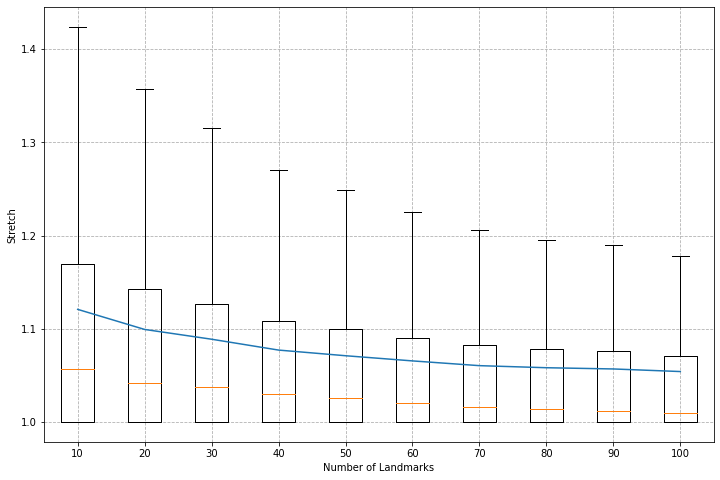

In [25]:
fig, ax = plt.subplots(1,1,figsize = (12,8))
ax.boxplot(np.transpose(stretch_all), showfliers=False)
ax.plot(np.linspace(1,10,10),np.mean(np.transpose(stretch_all), axis = 0))
ax.set_xticklabels(number_of_landmarks_list)
ax.set_xlabel('Number of Landmarks')
ax.set_ylabel('Stretch')
ax.grid(ls = '--')
plt.show()

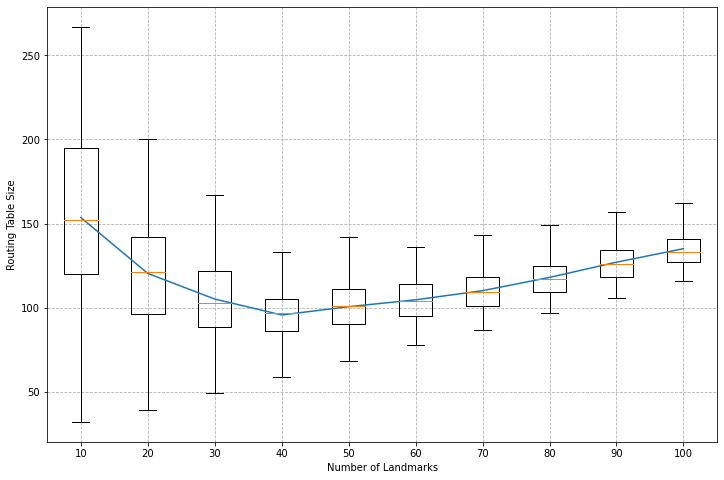

In [26]:
fig, ax = plt.subplots(1,1,figsize = (12,8))
ax.boxplot(np.transpose(routing_table_size), showfliers=False)
ax.plot(np.linspace(1,10,10),np.mean(np.transpose(routing_table_size), axis = 0))
ax.set_xticklabels(number_of_landmarks_list)
ax.set_xlabel('Number of Landmarks')
ax.set_ylabel('Routing Table Size')
ax.grid(ls = '--')
plt.show()

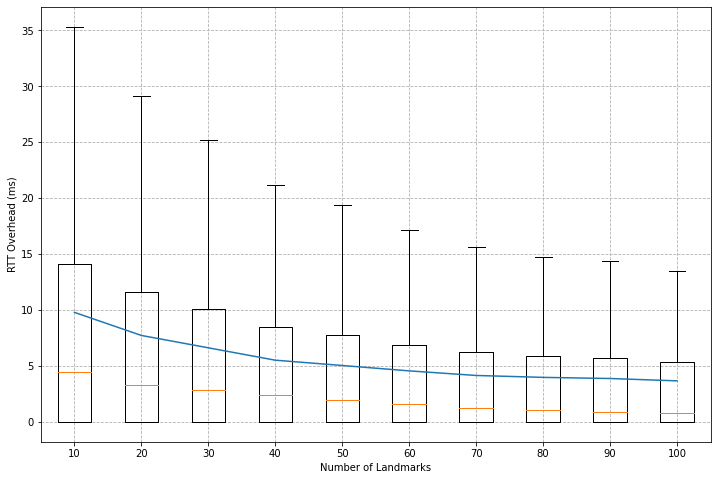

In [27]:
shortest_path_initfig, ax = plt.subplots(1,1,figsize = (12,8))
ax.boxplot(np.transpose(rtt_cost)*1000, showfliers=False)
ax.plot(np.linspace(1,10,10),np.mean(np.transpose(rtt_cost)*1000, axis = 0))
ax.set_xticklabels(number_of_landmarks_list)
ax.set_xlabel('Number of Landmarks')
ax.set_ylabel('RTT Overhead (ms)')
ax.grid(ls = '--')
plt.show()

In [28]:
test = net_utils.create_a_levels(ori_graph,3)

1584
130
9


In [29]:
#nx.write_gexf(ori_graph,"sat.gexf")

#### weighted-degree-based landmark choice algorithm (Failed Approaches, just skip it)

In [30]:
# weighted_degree = dict(graph.degree(weight = 'weight'))
# weighted_degree = {k: v for k, v in sorted(weighted_degree.items(), key=lambda item: item[1])}

In [31]:
# distance = []
# for k,v in weighted_degree.items():
#     distance.append(v)
# distance = np.array(distance)

In [32]:
# probability = distance/(MAX_NUM_LASER_LINK * MAX_DISTANCE_BETWEEN_SATS) 

In [33]:
# landmarkSets = []
# landmarkSet = []
# for i in range(len(number_of_landmarks_list)):    
#     while len(landmarkSet) < number_of_landmarks_list[i]:
#         for k, v in weighted_degree.items():
#             if len(landmarkSet) < number_of_landmarks_list[i]:
#                 prob = v / (MAX_NUM_LASER_LINK * MAX_DISTANCE_BETWEEN_SATS)    # probability of the node being chosen as the landmark
#                 rand_prob = np.random.rand()
#                 if rand_prob < prob and k not in landmarkSet:
#                     landmarkSet.append(k)
#     landmarkSets.append(copy.deepcopy(landmarkSet))

In [34]:
# landmarkSets = []
# for number_of_landmarks in number_of_landmarks_list: 
#     landmarkSets.append(list(np.round(np.linspace(0,len(graph.nodes())-1, number_of_landmarks)).astype(int)))

In [35]:
# dijkstra_count_all_node = {}
# for i in range(len(all_paths)):
#     node = all_paths[i]
#     for k,v in node.items():
#         for element in v[0][1:-1]:
            
#             if element not in dijkstra_count_all_node.keys():
#                 dijkstra_count_all_node.update({element: 1})
#             else:
#                 count = dijkstra_count_all_node[element]
#                 count += 1
#                 dijkstra_count_all_node.update({element: count})

In [36]:
# dijkstra_count_all_node = {}
# all_list = []
# for i in range(len(all_paths)):
#     node = all_paths[i]
#     list_temp = []pathToLandmark[0].index(hop)
#     for k,v in node.items():
#         list_temp.extend(v[0][1:-1])
#     all_list.append(list(set(list_temp)))
    
# for elements in all_list:
#     for element in elements:
#         if element not in dijkstra_count_all_node.keys():
#             dijkstra_count_all_node.update({element: 1})
#         else:
#             count = dijkstra_count_all_node[element]
#             count += 1
#             dijkstra_count_all_node.update({element: count})

In [37]:
# sorted_dijkstra_count_all_node = {k: v for k, v in sorted(dijkstra_count_all_node.items(), key=lambda item: item[1], reverse = True)}

In [38]:
# def kernel_func(all_paths_length, l):
#     stretch = 0
#     for s in range(len(all_paths_length)):
#         for d in range(len(all_paths_length)):
#             if s!=d:
#                 Dsl = all_paths_length[s,l]
#                 Dld = all_paths_length[l,d]
#                 Dsd = all_paths_length[s,d]
#                 if Dsd > Dsl and Dsd > Dld:
#                     stretch += (Dsl + Dld)/Dsd
#     clear_output(wait = True)
#     return [l, stretch]

In [39]:
# # create multiprocessing_args
# multiprocessing_args = []
# for node in range(len(all_paths)):
#     multiprocessing_args.append((copy.deepcopy(all_paths_length), node))

In [40]:
# index = list(range(len(multiprocessing_args)))
# seg_length = 20
# segment = [index[x:x+seg_length] for x in range(0,len(index),seg_length)]
# out = []
# for i in range(len(segment)):
#     print('working on segment ' + str(i+1) + '/' + str(len(segment)))
#     with Pool(len(segment[i])) as p:
#         out.extend(p.starmap(kernel_func, [multiprocessing_args[segment[i][j]] for j in range(len(segment[i]))]))
#     clear_output(wait = True)

In [41]:
# stretch_dict = {}
# for stretch in out:
#     stretch_dict.update({stretch[0]:stretch[1]})
# stretch_dict = {k: v for k, v in sorted(stretch_dict.items(), key=lambda item: item[1])}

In [42]:
# sorted_node = list(stretch_dict .keys())

In [43]:
# landmarkSets = []
# landmarkSet = []
# for number_of_landmarks in number_of_landmarks_list:    
#     landmarkSets.append(sorted_node[:number_of_landmarks])

#### Uniformly-sample sphere landmark picking approach

In [44]:
def get_landmark_idx(spaceX_positions, number_of_landmarks):
    uniform_sphere_sample = geom.fibonacci_sphere(number_of_landmarks)[1]
    distance_matrix = np.zeros((number_of_landmarks,NUMBER_OF_NODES))
    for point_idx, point in enumerate(uniform_sphere_sample):
        distance_temp = np.zeros((NUMBER_OF_NODES))
        for orbit_idx, orbit in enumerate(spaceX_positions):
            for sat_idx, satellite in enumerate(orbit):
                dist = geom.haversine(point,satellite, ALTITUDE)
                sat_idx_global = sat.get_node_number(orbit_idx,sat_idx)
                distance_temp[sat_idx_global] = dist
        distance_matrix[point_idx,:] = distance_temp
    
    landmarks = []
    for i in range(number_of_landmarks):
        find_landmark = False
        while not(find_landmark):
            landmark = np.argmin(distance_matrix[i,:])
            if landmark not in landmarks:
                landmarks.append(landmark)
                find_landmark = True
            else:
                distance_matrix[i,landmark] = np.inf
    return landmarks

In [45]:
uniform_sphere_sample = geom.fibonacci_sphere(10)[1]

In [46]:
# def get_landmark_idx(spaceX_positions, number_of_landmarks):
#     uniform_sphere_sample_init = geom.fibonacci_sphere(number_of_landmarks)[1]
    
#     anchor_lat = np.inf
#     anchor_idx = 0
#     for idx, pos in enumerate(spaceX_positions[0]):
#         if np.abs(pos[1])<anchor_lat:
#             anchor_lat = np.abs(pos[1])
#             anchor_idx = idx
    
#     anchor = spaceX_positions[0][anchor_idx]
#     lat_offset = anchor[0]-uniform_sphere_sample_init[0][0]
#     lon_offset = anchor[1]-uniform_sphere_sample_init[0][1]
    
#     uniform_sphere_sample = []
#     for point in uniform_sphere_sample_init:
#         lat_calib = point[0] + lat_offset
#         lon_calib = point[1] + lon_offset
#         lat_calib = np.angle(np.exp(1j*lat_calib))
#         lon_calib = np.angle(np.exp(1j*lon_calib))
#         uniform_sphere_sample.append((lat_calib,lon_calib))
    
#     distance_matrix = np.zeros((number_of_landmarks,NUMBER_OF_NODES))
#     for point_idx, point in enumerate(uniform_sphere_sample):
#         distance_temp = np.zeros((NUMBER_OF_NODES))
#         for orbit_idx, orbit in enumerate(spaceX_positions):
#             for sat_idx, satellite in enumerate(orbit):
#                 dist = geom.haversine(point,satellite, ALTITUDE)
#                 sat_idx_global = sat.get_node_number(orbit_idx,sat_idx)
#                 distance_temp[sat_idx_global] = dist
#         distance_matrix[point_idx,:] = distance_temp
    
#     landmarks = []
#     for i in range(number_of_landmarks):
#         find_landmark = False
#         while not(find_landmark):
#             landmark = np.argmin(distance_matrix[i,:])
#             if landmark not in landmarks:
#                 landmarks.append(landmark)
#                 find_landmark = True
#             else:
#                 distance_matrix[i,landmark] = np.inf
                
#     return landmarks

In [47]:
landmarkSets = []
for number_of_landmarks in number_of_landmarks_list:
    landmarkSets.append(get_landmark_idx(spaceX_positions, number_of_landmarks))
    print('finished')
    #clear_output(wait = True)

finished
finished
finished
finished
finished
finished
finished
finished
finished
finished


In [48]:
stretch_list_uniform = []  
stretch_all_uniform = []
routing_table_size_uniform = []
rtt_cost_uniform = []
for landmarkSet in landmarkSets:
    print('Now Working On number_of_landmarks = ' + str(len(landmarkSet)))
    
    graph = copy.deepcopy(ori_graph)
    
    pathSet = {}
    for landmark in landmarkSet:
        paths = copy.deepcopy(all_paths[landmark])
        del paths[landmark]
        pathSet[landmark] = paths
        
    for nodeId in graph.nodes():
        graph.nodes[nodeId]['paths'] = {}
        for landmark in landmarkSet:
            if nodeId != landmark:
                graph.nodes()[nodeId]['paths'][landmark] = pathSet[landmark][nodeId]

    #add a destination node to a node's cluster if the path to the destination is shorter than to any landmark node
    for nodeId in graph.nodes:
        graph.nodes[nodeId]['cluster'] = []
        
    for nodeId in graph.nodes:
        node = graph.nodes[nodeId]
        paths = copy.deepcopy(all_paths[nodeId])

        #find the closest landmark
        if nodeId == landmarkSet[0]:
            minLandmark = landmarkSet[1]
        else:
            minLandmark = landmarkSet[0]
        minDist = node['paths'][minLandmark][1]
        for landmark in landmarkSet:
            if nodeId != landmark:
                if node['paths'][landmark][1] < minDist:
                    minLandmark = landmark
                    minDist = node['paths'][landmark][1]

        #if the path to the node is shorter through another node than a landmark, add the node to the other node's cluster
        for destinationId in graph.nodes:
            if nodeId != destinationId:
                if paths[destinationId][1] < minDist or np.floor(nodeId/SATELLITES_PER_ORBIT) == np.floor(destinationId/SATELLITES_PER_ORBIT):
                    graph.nodes[destinationId]['cluster'].append(nodeId)
    
    #calculate routing_table_size
    cur_routing_table_size = []
    for nodeId in graph.nodes():
        routing_table = list(set(graph.nodes[nodeId]['cluster'] + landmarkSet))
        cur_routing_table_size.append(len(routing_table))
    routing_table_size_uniform.append(cur_routing_table_size)
    
    print('average_routing_table_size = ' + str(np.sum(cur_routing_table_size)/NUMBER_OF_NODES))
    
    #for each chosen node calculate landmark paths and set closest landmark
    for nodeId in graph.nodes():
        paths = copy.deepcopy(all_paths[nodeId])

        minLandmark = ''
        if nodeId == landmarkSet[0]:
            minLandmark = landmarkSet[1]
        else:
            minLandmark = landmarkSet[0]
        landmarkPath = paths[minLandmark]

        for landmark in landmarkSet:
            if paths[landmark][1] < landmarkPath[1]:
                minLandmark = landmark
                landmarkPath = paths[landmark]

        graph.nodes()[nodeId]['closestLandmark'] = [minLandmark, landmarkPath]
        
    totalPathStretch = 0.0
    pathstretch_record = []
    totalPaths = 0
    
    cur_rtt_cost = []
    #for each chosen node calculate shortest paths
    for nodeId in chosenNodes:
        paths = copy.deepcopy(all_paths[nodeId])
        #start by finding the path to the destination's closest landmark

        for destinationId in graph.nodes():
            if nodeId != destinationId:
                destination = graph.nodes()[destinationId]
                destinationLandmark = graph.nodes()[destinationId]['closestLandmark'][0]
                pathToLandmark = paths[destinationLandmark]
                clusterFound = False
                pathLength = 0
                #check if any nodes on the path to the landmark have the destination in their cluster
                for hop in pathToLandmark[0]:
                    if destinationId in graph.nodes()[hop]['cluster']:

                        clusterFound = True
                        pathLength = paths[hop][1]
                        pathFromClusterNode = all_paths[hop][destinationId][1]
                        pathLength = pathLength + pathFromClusterNode

                        pathStretch = pathLength/paths[destinationId][1]
                        pathstretch_record.append(pathStretch)
                        cur_rtt_cost.append((pathLength - paths[destinationId][1])*2*1000/light_speed)
                        shortestPath = paths[destinationId][0]
                        totalPathStretch = totalPathStretch + pathStretch
                        totalPaths = totalPaths + 1

                        break

                #if no cluster shortcut is found, use the shortest path
                if not clusterFound:
                    pathLength = pathToLandmark[1] + graph.nodes()[destinationId]['closestLandmark'][1][1]

                    pathStretch = pathLength/paths[destinationId][1]
                    pathstretch_record.append(pathStretch)
                    cur_rtt_cost.append((pathLength - paths[destinationId][1])*2*1000/light_speed)
                    totalPathStretch = totalPathStretch + pathStretch
                    totalPaths = totalPaths + 1

    print('Stretch when number_of_landmarks = ' + str(len(landmarkSet)))
    stretch_list_uniform.append(round(totalPathStretch / totalPaths, 4))
    stretch_all_uniform.append(pathstretch_record)
    rtt_cost_uniform.append(cur_rtt_cost)
    print(round(totalPathStretch / totalPaths, 4))  

Now Working On number_of_landmarks = 10
average_routing_table_size = 139.3844696969697
Stretch when number_of_landmarks = 10
1.0983
Now Working On number_of_landmarks = 20
average_routing_table_size = 91.45707070707071
Stretch when number_of_landmarks = 20
1.0823
Now Working On number_of_landmarks = 30
average_routing_table_size = 85.21969696969697
Stretch when number_of_landmarks = 30
1.0753
Now Working On number_of_landmarks = 40
average_routing_table_size = 90.43181818181819
Stretch when number_of_landmarks = 40
1.0706
Now Working On number_of_landmarks = 50
average_routing_table_size = 91.21906565656566
Stretch when number_of_landmarks = 50
1.0635
Now Working On number_of_landmarks = 60
average_routing_table_size = 99.82575757575758
Stretch when number_of_landmarks = 60
1.061
Now Working On number_of_landmarks = 70
average_routing_table_size = 106.32638888888889
Stretch when number_of_landmarks = 70
1.0575
Now Working On number_of_landmarks = 80
average_routing_table_size = 114.364

#### Landmark Selection Based on Orbital Plane

In [49]:
def fibonacci_sphere(n):
    i = np.arange(0, n, dtype=float) + 0.5
    phi = np.arccos(1 - 2*i/n)
    goldenRatio = (1 + 5**0.5)/2
    theta = 2 * np.pi * i / goldenRatio
    x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi);
    
    points = []
    points_rad = []
    for i in range(len(x)):
        points.append((x[i], y[i], [i]))
        points_rad.append((np.angle(np.exp(1j*theta[i])), phi[i]-np.pi/2))
    
    return points, points_rad

In [50]:
def get_minimum_sphere_sep_distance(number_of_landmarks):
    uniform_sphere_sample = geom.fibonacci_sphere(number_of_landmarks)[1]
    dist = []
    for i, coord1 in enumerate(uniform_sphere_sample):
        cur_dist = []
        for j, coord2 in enumerate(uniform_sphere_sample):
            if i == j:
                continue
            d = geom.haversine(coord1, coord2, ALTITUDE)
            cur_dist.append(d)
        
        dist.append(np.mean(sorted(cur_dist)[:4]))
        
    return np.mean(dist)

TypeError: list indices must be integers or slices, not tuple

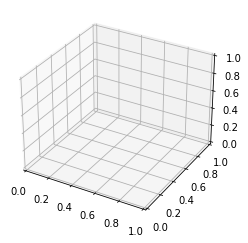

In [51]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(test[:,0], test[:,1], test[:,2]);

In [ ]:
landmarkSets = []
for number_of_landmarks in number_of_landmarks_list:
    min_d = get_minimum_sphere_sep_distance(number_of_landmarks)/2
    if number_of_landmarks <= NUMBER_OF_ORBITS:
        orbit_idxs= np.round(np.linspace(0,NUMBER_OF_ORBITS-1, number_of_landmarks)).astype(np.int)
        landmarkSet = []
        for orbit_idx in np.random.permutation(orbit_idxs):
            if landmarkSet == []:
                idx_landmark_orbit = np.random.randint(SATELLITES_PER_ORBIT)
                idx_landmark = sat.get_node_number(orbit_idx,idx_landmark_orbit)
                landmarkSet.append(idx_landmark)
            else:
                Find = False
                while Find == False:
                    idx_landmark_orbit = np.random.randint(SATELLITES_PER_ORBIT)
                    idx_landmark = sat.get_node_number(orbit_idx,idx_landmark_orbit)
                    dist = []
                    for landmark in landmarkSet:
                        dist.append(geom.haversine(spaceX_positions_global_idx[landmark], spaceX_positions_global_idx[idx_landmark], ALTITUDE))
                    if np.min(dist) > min_d:
                        landmarkSet.append(idx_landmark)
                        Find = True               
        landmarkSets.append(landmarkSet)

    else:
        number_of_landmarks_per_orbit = int(np.floor(number_of_landmarks/NUMBER_OF_ORBITS))
        residual_landmarks = number_of_landmarks - number_of_landmarks_per_orbit * NUMBER_OF_ORBITS
        landmarkSet = []
        for i in np.random.permutation(list(range(NUMBER_OF_ORBITS))):#range(NUMBER_OF_ORBITS):
            for j in range(number_of_landmarks_per_orbit):
                if landmarkSet == []:
                    idx_landmark_orbit = np.random.randint(SATELLITES_PER_ORBIT)
                    idx_landmark = sat.get_node_number(i,idx_landmark_orbit)
                    landmarkSet.append(idx_landmark)
                else:
                    Find = False
                    while Find == False:
                        idx_landmark_orbit = np.random.randint(SATELLITES_PER_ORBIT)
                        idx_landmark = sat.get_node_number(i,idx_landmark_orbit)
                        dist = []
                        for landmark in landmarkSet:
                            dist.append(geom.haversine(spaceX_positions_global_idx[landmark], spaceX_positions_global_idx[idx_landmark], ALTITUDE))
                        if np.min(dist) > min_d:
                            landmarkSet.append(idx_landmark)
                            Find = True
        for _ in range(residual_landmarks):
            find = False
            while find == False:
                idx_landmark = np.random.randint(NUMBER_OF_NODES)
                if idx_landmark not in landmarkSet:
                    dist = []
                    for landmark in landmarkSet:
                        dist.append(geom.haversine(spaceX_positions_global_idx[landmark], spaceX_positions_global_idx[idx_landmark], ALTITUDE))
                    if np.min(dist) > min_d:
                        landmarkSet.append(idx_landmark)
                        find = True

        landmarkSets.append(landmarkSet)

In [ ]:
stretch_list_orbit_sampling = []      
stretch_all_orbit_sampling = []   
routing_table_size_orbit_sampling = []
rtt_cost_orbit_sampling = []
for landmarkSet in landmarkSets:
    print('Now Working On number_of_landmarks = ' + str(len(landmarkSet)))
    
    graph = copy.deepcopy(ori_graph)
    
    pathSet = {}
    for landmark in landmarkSet:
        paths = copy.deepcopy(all_paths[landmark])
        del paths[landmark]
        pathSet[landmark] = paths
        
    for nodeId in graph.nodes():
        graph.nodes[nodeId]['paths'] = {}
        for landmark in landmarkSet:
            if nodeId != landmark:
                graph.nodes()[nodeId]['paths'][landmark] = pathSet[landmark][nodeId]

    #add a destination node to a node's cluster if the path to the destination is shorter than to any landmark node
    for nodeId in graph.nodes:
        graph.nodes[nodeId]['cluster'] = []
        
    for nodeId in graph.nodes:
        node = graph.nodes[nodeId]
        paths = copy.deepcopy(all_paths[nodeId])

        #find the closest landmark
        if nodeId == landmarkSet[0]:
            minLandmark = landmarkSet[1]
        else:
            minLandmark = landmarkSet[0]
        minDist = node['paths'][minLandmark][1]
        for landmark in landmarkSet:
            if nodeId != landmark:
                if node['paths'][landmark][1] < minDist:
                    minLandmark = landmark
                    minDist = node['paths'][landmark][1]

        #if the path to the node is shorter through another node than a landmark, add the node to the other node's cluster
        for destinationId in graph.nodes:
            if nodeId != destinationId:
                if paths[destinationId][1] < minDist or np.floor(nodeId/SATELLITES_PER_ORBIT) == np.floor(destinationId/SATELLITES_PER_ORBIT):
                    graph.nodes[destinationId]['cluster'].append(nodeId)
    
    #calculate routing_table_size
    cur_routing_table_size = []
    for nodeId in graph.nodes():
        routing_table = list(set(graph.nodes[nodeId]['cluster'] + landmarkSet))
        cur_routing_table_size.append(len(routing_table))
    routing_table_size_orbit_sampling.append(cur_routing_table_size)
    
    print('average_routing_table_size = ' + str(np.sum(cur_routing_table_size)/NUMBER_OF_NODES))
    
    #for each chosen node calculate landmark paths and set closest landmark
    for nodeId in graph.nodes():
        paths = copy.deepcopy(all_paths[nodeId])

        minLandmark = ''
        if nodeId == landmarkSet[0]:
            minLandmark = landmarkSet[1]
        else:
            minLandmark = landmarkSet[0]
        landmarkPath = paths[minLandmark]

        for landmark in landmarkSet:
            if paths[landmark][1] < landmarkPath[1]:
                minLandmark = landmark
                landmarkPath = paths[landmark]

        graph.nodes()[nodeId]['closestLandmark'] = [minLandmark, landmarkPath]
        
    totalPathStretch = 0.0
    pathstretch_record = []
    totalPaths = 0

    #for each chosen node calculate shortest paths
    cur_rtt_cost = []
    for nodeId in chosenNodes:
        paths = copy.deepcopy(all_paths[nodeId])
        #start by finding the path to the destination's closest landmark

        for destinationId in graph.nodes():
            if nodeId != destinationId:
                destination = graph.nodes()[destinationId]
                destinationLandmark = graph.nodes()[destinationId]['closestLandmark'][0]
                pathToLandmark = paths[destinationLandmark]
                clusterFound = False
                pathLength = 0
                #check if any nodes on the path to the landmark have the destination in their cluster
                for hop in pathToLandmark[0]:
                    if destinationId in graph.nodes()[hop]['cluster']:

                        clusterFound = True
                        pathLength = paths[hop][1]
                        pathFromClusterNode = all_paths[hop][destinationId][1]
                        pathLength = pathLength + pathFromClusterNode

                        pathStretch = pathLength/paths[destinationId][1]
                        pathstretch_record.append(pathStretch)
                        cur_rtt_cost.append((pathLength - paths[destinationId][1])*2*1000/light_speed)
                        shortestPath = paths[destinationId][0]
                        totalPathStretch = totalPathStretch + pathStretch
                        totalPaths = totalPaths + 1

                        break

                #if no cluster shortcut is found, use the shortest path
                if not clusterFound:
                    pathLength = pathToLandmark[1] + graph.nodes()[destinationId]['closestLandmark'][1][1]

                    pathStretch = pathLength/paths[destinationId][1]
                    pathstretch_record.append(pathStretch)
                    cur_rtt_cost.append((pathLength - paths[destinationId][1])*2*1000/light_speed)
                    totalPathStretch = totalPathStretch + pathStretch
                    totalPaths = totalPaths + 1

    print('Stretch when number_of_landmarks = ' + str(len(landmarkSet)))
    stretch_list_orbit_sampling.append(round(totalPathStretch / totalPaths, 4))
    stretch_all_orbit_sampling.append(pathstretch_record)
    rtt_cost_orbit_sampling.append(cur_rtt_cost)
    print(round(totalPathStretch / totalPaths, 4))      

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(16,8), gridspec_kw={'width_ratios': [1,]})
ax.plot(number_of_landmarks_list,stretch_list)
ax.plot(number_of_landmarks_list,stretch_list_uniform)
ax.plot(number_of_landmarks_list,stretch_list_orbit_sampling)
ax.legend(['Random','Geo-uniform','orbit_sampling'])
ax.set_xlabel('Number of Landmarks')
ax.set_ylabel('Average Stretch')
ax.grid(linestyle='--')

#### Plot

In [ ]:
stretch_data = np.array([stretch_all, stretch_all_uniform, stretch_all_orbit_sampling])
routing_table_size_data = np.array([routing_table_size, routing_table_size_uniform, routing_table_size_orbit_sampling])
rtt_cost_data = np.array([rtt_cost, rtt_cost_uniform, rtt_cost_orbit_sampling])

In [ ]:
data = []
algorithms = ['Random','Fibonacci Sampling', 'Orbital Uniform Sampling']
for i in range(3):
    for j in range(10):
        for k in range(251697):
            data.append([stretch_data[i,j,k],algorithms[i],number_of_landmarks_list[j]])

In [ ]:
data = pd.DataFrame(data, columns = ["Stretch","Algorithm","Number of Landmarks"])

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns
import ptitprince as pt
import numpy as np
import scipy.io as sio
import statsmodels
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns
import itertools
from matplotlib.patches import PathPatch

In [ ]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [ ]:
from fontTools.ttLib import TTFont
font = TTFont("/usr/share/fonts/truetype/myfonts/Helvetica.ttf", fontNumber=0)
font.save("Helvetica.ttf")

In [ ]:
fm = font_manager.json_load("/home/changhan/.cache/matplotlib/fontlist-v330.json")
fm.findfont("serif", rebuild_if_missing=False)
fm.findfont("serif", fontext="afm", rebuild_if_missing=False)

In [ ]:
plt.rcParams.update({'font.size': 30, "font.family":'sans-serif'})
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams["axes.edgecolor"] = "0.5"
plt.rcParams["axes.linewidth"]  = 4
plt.rcParams["axes.spines.right"]  = False
plt.rcParams["axes.spines.top"]  = False

In [ ]:
def adjust_box_widths(ax, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through axes artists:
    for c in ax.get_children():

        # searching for PathPatches
        if isinstance(c, PathPatch):
            # getting current width of box:
            p = c.get_path()
            verts = p.vertices
            verts_sub = verts[:-1]
            xmin = np.min(verts_sub[:, 0])
            xmax = np.max(verts_sub[:, 0])
            xmid = 0.5*(xmin+xmax)
            xhalf = 0.5*(xmax - xmin)

            # setting new width of box
            xmin_new = xmid-fac*xhalf
            xmax_new = xmid+fac*xhalf
            verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
            verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

            # setting new width of median line
            for l in ax.lines:
                if np.all(l.get_xdata() == [xmin, xmax]):
                    l.set_xdata([xmin_new, xmax_new])

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,8), gridspec_kw={'width_ratios': [1,]})
sns.boxplot(ax = ax,y = "Stretch", x = "Number of Landmarks", hue_order = ["Random","Fibonacci Sampling", "Orbital Uniform Sampling"], 
                  data = data, hue = "Algorithm",showfliers = False)
linecolors = ['maroon','steelblue','black']
for i in range(3):
    ax.plot(np.linspace(0,9,10),np.mean(np.squeeze(np.transpose(stretch_data[i])), axis = 0),c = linecolors[i])
#ax3.legend(loc='upper left')
ax.grid(True, which="both",ls="--", lw=2)
ax.xaxis.label.set_size(30)
ax.yaxis.label.set_size(30)
ax.tick_params(axis='both', which='major',labelsize=30)
ax.set(ylim = [0.98,1.451], yticks = [1,1.15,1.3,1.45])

adjust_box_widths(ax, 0.85)

hatches = ['//', 'x', '+','//', 'x', '+','//', 'x', '+',
           '//', 'x', '+','//', 'x', '+','//', 'x', '+',
           '//', 'x', '+','//', 'x', '+','//', 'x', '+',
           '//', 'x', '+']
edge_colors = ['maroon','steelblue','black','maroon','steelblue','black','maroon','steelblue','black',
               'maroon','steelblue','black','maroon','steelblue','black','maroon','steelblue','black',
               'maroon','steelblue','black','maroon','steelblue','black','maroon','steelblue','black',
               'maroon','steelblue','black']
count = 0
for hatch, edge_color, patch, line in zip(hatches, edge_colors,ax.artists,ax.lines):
    patch.set_hatch(hatch)
    patch.set(facecolor='white')
    patch.set(edgecolor = edge_color)
    patch.set_alpha(0.75)
    for j in range(count*5,count*5+5):
        line = ax.lines[j]
        line.set_color(edge_color)
        line.set_mfc(edge_color)
        line.set_mec(edge_color)
    count += 1

ax.legend(ax.artists,["Random","Fibonacci Sampling", "Orbital Uniform Sampling"], fancybox=False, framealpha=0, prop={'size':30})

In [ ]:
data = []
algorithms = ['Random','Fibonacci Sampling', 'Orbital Uniform Sampling']
for i in range(3):
    for j in range(10):
        for k in range(1584):
            data.append([routing_table_size_data[i,j,k],algorithms[i],number_of_landmarks_list[j]])

In [ ]:
data = pd.DataFrame(data, columns = ["Routing Table Size","Algorithm","Number of Landmarks"])

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,8), gridspec_kw={'width_ratios': [1,]})
sns.boxplot(ax = ax,y = "Routing Table Size", x = "Number of Landmarks", hue_order = ["Random","Fibonacci Sampling", "Orbital Uniform Sampling"], 
                  data = data, hue = "Algorithm",showfliers = False)
#linecolors = ['maroon','steelblue','black']
#for i in range(3):
#    ax.plot(np.linspace(0,9,10),np.mean(np.squeeze(np.transpose(stretch_data[i])), axis = 0),c = linecolors[i])
#ax3.legend(loc='upper left')
ax.grid(True, which="both",ls="--", lw=2)
ax.xaxis.label.set_size(30)
ax.yaxis.label.set_size(30)
ax.tick_params(axis='both', which='major',labelsize=30)
#ax.set(ylim = [0.98,1.451], yticks = [1,1.15,1.3,1.45])

adjust_box_widths(ax, 0.85)

hatches = ['//', 'x', '+','//', 'x', '+','//', 'x', '+',
           '//', 'x', '+','//', 'x', '+','//', 'x', '+',
           '//', 'x', '+','//', 'x', '+','//', 'x', '+',
           '//', 'x', '+']
edge_colors = ['maroon','steelblue','black','maroon','steelblue','black','maroon','steelblue','black',
               'maroon','steelblue','black','maroon','steelblue','black','maroon','steelblue','black',
               'maroon','steelblue','black','maroon','steelblue','black','maroon','steelblue','black',
               'maroon','steelblue','black']
count = 0
for hatch, edge_color, patch, line in zip(hatches, edge_colors,ax.artists,ax.lines):
    patch.set_hatch(hatch)
    patch.set(facecolor='white')
    patch.set(edgecolor = edge_color)
    patch.set_alpha(0.75)
    for j in range(count*5,count*5+5):
        line = ax.lines[j]
        line.set_color(edge_color)
        line.set_mfc(edge_color)
        line.set_mec(edge_color)
    count += 1

ax.legend(ax.artists,["Random","Fibonacci Sampling", "Orbital Uniform Sampling"], fancybox=False, framealpha=0, prop={'size':30})

In [ ]:
data = []
algorithms = ['Random','Fibonacci Sampling', 'Orbital Uniform Sampling']
for i in range(3):
    for j in range(10):
        for k in range(1584):
            data.append([rtt_cost_data[i,j,k]*1000,algorithms[i],number_of_landmarks_list[j]])

In [ ]:
data = pd.DataFrame(data, columns = ["RTT Overhead (ms)","Algorithm","Number of Landmarks"])

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,8), gridspec_kw={'width_ratios': [1,]})
sns.boxplot(ax = ax,y = "RTT Overhead (ms)", x = "Number of Landmarks", hue_order = ["Random","Fibonacci Sampling", "Orbital Uniform Sampling"], 
                  data = data, hue = "Algorithm",showfliers = False)
#linecolors = ['maroon','steelblue','black']
#for i in range(3):
#    ax.plot(np.linspace(0,9,10),np.mean(np.squeeze(np.transpose(stretch_data[i])), axis = 0),c = linecolors[i])
#ax3.legend(loc='upper left')
ax.grid(True, which="both",ls="--", lw=2)
ax.xaxis.label.set_size(30)
ax.yaxis.label.set_size(30)
ax.tick_params(axis='both', which='major',labelsize=30)
#ax.set(ylim = [0.98,1.451], yticks = [1,1.15,1.3,1.45])

adjust_box_widths(ax, 0.85)

hatches = ['//', 'x', '+','//', 'x', '+','//', 'x', '+',
           '//', 'x', '+','//', 'x', '+','//', 'x', '+',
           '//', 'x', '+','//', 'x', '+','//', 'x', '+',
           '//', 'x', '+']
edge_colors = ['maroon','steelblue','black','maroon','steelblue','black','maroon','steelblue','black',
               'maroon','steelblue','black','maroon','steelblue','black','maroon','steelblue','black',
               'maroon','steelblue','black','maroon','steelblue','black','maroon','steelblue','black',
               'maroon','steelblue','black']
count = 0
for hatch, edge_color, patch, line in zip(hatches, edge_colors,ax.artists,ax.lines):
    patch.set_hatch(hatch)
    patch.set(facecolor='white')
    patch.set(edgecolor = edge_color)
    patch.set_alpha(0.75)
    for j in range(count*5,count*5+5):
        line = ax.lines[j]
        line.set_color(edge_color)
        line.set_mfc(edge_color)
        line.set_mec(edge_color)
    count += 1

ax.legend(ax.artists,["Random","Fibonacci Sampling", "Orbital Uniform Sampling"], fancybox=False, framealpha=0, prop={'size':30})

#### K-shell clustering

In [ ]:
def check(h, d):
    f = 0  # there is no node of deg <= d
    for i in h.nodes():
        if (h.degree(i) <= d):
            f = 1
            break
    return f

# Find list of nodes with particular degree
def find_nodes(h, it):
    set1 = []
    for i in h.nodes():
        if (h.degree(i) <= it):
            set1.append(i)
    return set1

In [ ]:
# Copy the graph
h = graph.copy()
it = 1
 
#Bucket being filled currently
tmp = []

# list of lists of buckets
buckets = []
while (1):
    flag = check(h, it)
    if (flag == 0):
        it += 1
        buckets.append(tmp)
        tmp = []
    if (flag == 1):
        node_set = find_nodes(h, it)
        for each in node_set:
            h.remove_node(each)
            tmp.append(each)
    if (h.number_of_nodes() == 0):
        buckets.append(tmp)
        break
#buckets = [bucket for bucket in buckets if bucket != []]

In [ ]:
buckets = buckets[::-1]

In [ ]:
bucket_length = [0]
cur_length = 0
for bucket in buckets:
    cur_length += len(bucket)
    bucket_length.append(cur_length)

In [ ]:
bucket_length_lower = np.array(bucket_length[:-1])
bucket_length_upper = np.array(bucket_length[1:])

In [ ]:
def which_bucket(length, bucket_length_lower, bucket_length_upper):
    return np.where((length>=bucket_length_lower)&(length<bucket_length_upper))[0][0]

In [ ]:
landmarkSets = []
landmarkSet = []
for i in range(len(number_of_landmarks_list)):
    while len(landmarkSet) < number_of_landmarks_list[i]:
        idx = which_bucket(len(landmarkSet), bucket_length_lower, bucket_length_upper)
        landmark = random.choice(buckets[idx]) 
        if landmark not in landmarkSet:
            landmarkSet.append(landmark)
            buckets[idx].remove(landmark)
    landmarkSets.append(copy.deepcopy(landmarkSet))

In [ ]:
stretch_list_kshell = []

#Pick Test Nodes
n = int(graph.number_of_nodes() / 10) + 1
chosenNodes = random.sample(range(graph.number_of_nodes()), n)        
            
for landmarkSet in landmarkSets:
    print('Now Working On number_of_landmarks = ' + str(len(landmarkSet)))
    
    graph = sat.create_full_mesh()
    
    pathSet = {}
    for landmark in landmarkSet:
        paths = copy.deepcopy(all_paths[landmark])
        del paths[landmark]
        pathSet[landmark] = paths
        
    for node in graph.nodes():
        graph.nodes[node]['paths'] = {}
        for landmark in landmarkSet:
            if node != landmark:
                graph.nodes()[node]['paths'][landmark] = pathSet[landmark][node][0]
    
    pathLenTotal = 0
    numPaths = 0
    pathLenFreq = {}

    #add a destination node to a node's cluster if the path to the destination is shorter than to any landmark node
    for nodeId in graph.nodes:
        node = graph.nodes[nodeId]
        cluster = {}
        paths = copy.deepcopy(all_paths[nodeId])

        #find the closest landmark
        if nodeId == landmarkSet[0]:
            minLandmark = landmarkSet[1]
        else:
            minLandmark = landmarkSet[0]
        minDist = node['paths'][minLandmark][1]
        for landmark in landmarkSet:
            if nodeId != landmark:
                if node['paths'][landmark][1] < minDist:
                    minLandmark = landmark
                    minDist = node['paths'][landmark][1]

        #if the path to the node is shorter through another node than a landmark, add the node to the other node's cluster
        for destinationId in graph.nodes:
            if nodeId != destinationId:

                pathLenTotal = pathLenTotal + paths[destinationId][1]
                numPaths = numPaths + 1
                if paths[destinationId][1] not in pathLenFreq.keys():
                    pathLenFreq[paths[destinationId][1]] = 1
                else:
                    pathLenFreq[paths[destinationId][1]] = pathLenFreq[paths[destinationId][1]] + 1

                if paths[destinationId][1] < minDist:
                    destination = graph.nodes[destinationId]
                    try:
                        destination['cluster'][nodeId] = paths[destinationId][0][-2]
                    except:
                        destination['cluster'] = {}
                        destination['cluster'][nodeId] = paths[destinationId][0][-2]
        graph.nodes[nodeId]['cluster'] = cluster

    #for each chosen node calculate landmark paths and set closest landmark
    for nodeId in list(graph.nodes().keys()):
        paths = copy.deepcopy(all_paths[nodeId])

        minLandmark = ''
        if nodeId == landmarkSet[0]:
            minLandmark = landmarkSet[1]
        else:
            minLandmark = landmarkSet[0]
        landmarkPath = paths[minLandmark]

        for landmark in landmarkSet:
            if paths[landmark][1] < landmarkPath[1]:
                minLandmark = landmark
                landmarkPath = paths[landmark]

        graph.nodes()[nodeId]['closestLandmark'] = [minLandmark, landmarkPath]
        
    totalPathStretch = 0.0
    totalPaths = 0

    #for each chosen node calculate shortest paths
    for nodeId in chosenNodes:
        paths = copy.deepcopy(all_paths[nodeId])
        #start by finding the path to the destination's closest landmark

        for destinationId in graph.nodes():
            if nodeId != destinationId:
                destination = graph.nodes()[destinationId]
                destinationLandmark = graph.nodes()[destinationId]['closestLandmark'][0]
                pathToLandmark = paths[destinationLandmark]
                clusterFound = False
                pathLength = 0
                #check if any nodes on the path to the landmark have the destination in their cluster
                for hop in pathToLandmark[0]:
                    if destinationId in graph.nodes()[hop]['cluster'].keys():

                        clusterFound = True
                        pathLength = nx.shortest_path_length(graph, nodeId, hop, weight = "weight")
                        pathFromClusterNode = nx.shortest_path_length(graph, hop, destinationId, weight = "weight")
                        pathLength = pathLength + pathFromClusterNode

                        pathStretch = 100/float(paths[destinationId][1]) * float(pathLength)
                        shortestPath = paths[destinationId][0]
                        totalPathStretch = totalPathStretch + pathStretch
                        totalPaths = totalPaths + 1

                        break

                #if no cluster shortcut is found, use the shortest path
                if not clusterFound:
                    pathLength = pathToLandmark[1] + graph.nodes()[destinationId]['closestLandmark'][1][1]

                    pathStretch = (100/float(paths[destinationId][1])) * float(pathLength)
                    totalPathStretch = totalPathStretch + pathStretch
                    totalPaths = totalPaths + 1

    print('Stretch when number_of_landmarks = ' + str(len(landmarkSet)))
    stretch_list_kshell.append(round((float(totalPathStretch) / float(totalPaths)) /100, 4))
    print(round((float(totalPathStretch) / float(totalPaths)) /100, 4))      

In [ ]:
plt.plot(number_of_landmarks_list,stretch_list)
plt.plot(number_of_landmarks_list,stretch_list_kshell)
plt.legend(['Random','K-Shell'])
plt.xlabel('Number of Landmarks')
plt.ylabel('Average Stretch')
plt.grid(linestyle='--')

#### Create multiple snapshots

In [ ]:
n_snap = 100

In [ ]:
OBSERVATION_DATE_START = '2022/03/30 08:00:00.000000'
#OBSERVATION_DATE_END = '2022/03/30 09:35:00.000000'
OBSERVATION_DATE_END = '2022/03/30 08:04:59.900000'
date_format = "%Y/%m/%d %H:%M:%S.%f"

In [ ]:
OBSERVATION_DATE_START_ts = datetime.timestamp(datetime.strptime(OBSERVATION_DATE_START, date_format))
OBSERVATION_DATE_END_ts = datetime.timestamp(datetime.strptime(OBSERVATION_DATE_END, date_format))

In [ ]:
# Interpolate to get the snapshots
OBSERVATION_DATES_ts = list(np.linspace(OBSERVATION_DATE_START_ts,OBSERVATION_DATE_END_ts,n_snap))
OBSERVATION_DATES = [datetime.fromtimestamp(date).strftime(date_format) for date in OBSERVATION_DATES_ts]

In [ ]:
# create multiprocessing_args
multiprocessing_args = []
for date in OBSERVATION_DATES:
    multiprocessing_args.append((date, 4))

In [ ]:
index = list(range(len(multiprocessing_args)))
seg_length = 20
segment = [index[x:x+seg_length] for x in range(0,len(index),seg_length)]
graphs = []
for i in range(len(segment)):
    print('working on segment ' + str(i+1) + '/' + str(len(segment)))
    with Pool(len(segment[i])) as p:
        graphs.extend(p.starmap(sat.create_spaceX_graph, [multiprocessing_args[segment[i][j]] for j in range(len(segment[i]))]))
    clear_output(wait=True)

##### Calculate Shortest-path stability

In [ ]:
shortest_path_init = nx.algorithms.shortest_path(graphs[0], weight = 'weight')

In [ ]:
# stretch_stability = []
# rtt_stability = []
# for idx, graph in enumerate(graphs):
#     all_paths = []
#     for nodeId in graph.nodes():
#         all_paths.append(nx.algorithms.shortest_path(graph, source = nodeId, weight =  'weight'))
#         print('Finished node ' + str(nodeId))
#         clear_output(wait=True)
    
#     #get shortest pathlength of all nodes
#     all_paths_length = np.zeros((graph.number_of_nodes(),graph.number_of_nodes()))
#     for nodeId in graph.nodes():
#         cur_pathlength = nx.algorithms.shortest_path_length(graph, source = nodeId, weight =  'weight')
#         cur_pathlength_list = np.zeros((graph.number_of_nodes()))
#         for key, value in cur_pathlength.items():
#             all_paths[nodeId].update({key:[all_paths[nodeId][key], value]})
#             cur_pathlength_list[key] = value
#         all_paths_length[nodeId,:] = cur_pathlength_list
#         print('Finished node ' + str(nodeId))
#         clear_output(wait=True)
    
#     stretchs = []
#     rtt_diff = []
#     for sourceId in graph.nodes():
#         for destinationId in graph.nodes():
#             if sourceId != destinationId:
#                 pathlength_dij = all_paths_length[sourceId, destinationId]
#                 legacy_path = shortest_path_init[sourceId][destinationId]
#                 legacy_pathlength = 0 
#                 path_segments = []
#                 for hop_id, hop in enumerate(legacy_path):
#                     if hop_id + 1 != len(legacy_path):
#                         path_segments.append([hop, legacy_path[hop_id + 1]])
                
#                 for segment in path_segments:
#                     legacy_pathlength += all_paths_length[segment[0], segment[1]]
                
#                 stretch = legacy_pathlength/pathlength_dij
#                 rtt_diff.append((legacy_pathlength - pathlength_dij)*1000/light_speed)
#                 stretchs.append(stretch)
        
#         print('Finished graph ' + str(idx) + ' Source ' + str(sourceId))
#         clear_output(wait=True)
    
#     stretch_stability.append(stretchs)
#     rtt_stability.append(rtt_diff)
#     print('Stability for graph ' + str(idx) + ' is ' + str(np.mean(stretchs)))
#     print('Finished graph ' + str(idx))

In [ ]:
def kernel_function(graph, graph_init):
    shortest_path_init = nx.algorithms.shortest_path(graph_init, weight = 'weight')
    all_paths = []
    #get shortest pathlength of all nodes
    all_paths_length = np.zeros((graph.number_of_nodes(),graph.number_of_nodes()))
    for nodeId in graph.nodes():
        cur_pathlength = nx.algorithms.shortest_path_length(graph, source = nodeId, weight =  'weight')
        cur_pathlength_list = np.zeros((graph.number_of_nodes()))
        for key, value in cur_pathlength.items():
#             all_paths[nodeId].update({key:[all_paths[nodeId][key], value]})
            cur_pathlength_list[key] = value
        all_paths_length[nodeId,:] = cur_pathlength_list
#         print('Finished node ' + str(nodeId))
#         clear_output(wait=True)
    
    stretchs = []
    rtt_diff = []
    for sourceId in graph.nodes():
        for destinationId in graph.nodes():
            if sourceId != destinationId:
                pathlength_dij = all_paths_length[sourceId, destinationId]
                legacy_path = shortest_path_init[sourceId][destinationId]
                legacy_pathlength = 0 
                path_segments = []
                for hop_id, hop in enumerate(legacy_path):
                    if hop_id + 1 != len(legacy_path):
                        path_segments.append([hop, legacy_path[hop_id + 1]])
                
                for segment in path_segments:
                    legacy_pathlength += all_paths_length[segment[0], segment[1]]
                
                stretch = legacy_pathlength/pathlength_dij
                rtt_diff.append((legacy_pathlength - pathlength_dij)*1000/light_speed)
                stretchs.append(stretch)
    return [np.mean(stretchs), np.mean(rtt_diff)]

In [ ]:
# create multiprocessing_args
multiprocessing_args = []
for graph in graphs:
    multiprocessing_args.append((graph, graphs[0]))

In [ ]:
index = list(range(len(multiprocessing_args)))
seg_length = 10
segment = [index[x:x+seg_length] for x in range(0,len(index),seg_length)]
stretch_stability = []
rtt_stability = []
for i in range(len(segment)):
    print('working on segment ' + str(i+1) + '/' + str(len(segment)))
    with Pool(len(segment[i])) as p:
        out = p.starmap(kernel_function, [multiprocessing_args[segment[i][j]] for j in range(len(segment[i]))])
        for item in out:
            stretch_stability.append(item[0])
            rtt_stability.append(item[1])
    clear_output(wait=True)

In [ ]:
stretch_stability_data = np.array(stretch_stability)

In [ ]:
plt.plot(np.linspace(1,300,100),stretch_stability)
plt.xlabel('time (s)')
plt.ylabel('stretch')

#### Get Routing Table

In [ ]:
def get_routing_table(graph_in,landmarkSet): 
    graph = copy.deepcopy(graph_in)
    
    all_paths = []
    for nodeId in graph.nodes():
        all_paths.append(nx.algorithms.shortest_path(graph, source = nodeId, weight =  'weight'))
        #print('Finished node ' + str(nodeId))
        #clear_output(wait=True)
    
    #get shortest pathlength of all nodes
    all_paths_length = np.zeros((graph.number_of_nodes(),graph.number_of_nodes()))
    for nodeId in graph.nodes():
        cur_pathlength = nx.algorithms.shortest_path_length(graph, source = nodeId, weight =  'weight')
        cur_pathlength_list = np.zeros((graph.number_of_nodes()))
        for key, value in cur_pathlength.items():
            all_paths[nodeId].update({key:[all_paths[nodeId][key], value]})
            cur_pathlength_list[key] = value
        all_paths_length[nodeId,:] = cur_pathlength_list
    
    pathSet = {}
    for landmark in landmarkSet:
        paths = copy.deepcopy(all_paths[landmark])
        del paths[landmark]
        pathSet[landmark] = paths
        
    for nodeId in graph.nodes():
        graph.nodes[nodeId]['paths'] = {}
        for landmark in landmarkSet:
            if nodeId != landmark:
                graph.nodes()[nodeId]['paths'][landmark] = pathSet[landmark][nodeId]

    #add a destination node to a node's cluster if the path to the destination is shorter than to any landmark node
    for nodeId in graph.nodes:
        graph.nodes[nodeId]['cluster'] = []
        
    for nodeId in graph.nodes:
        node = graph.nodes[nodeId]
        paths = copy.deepcopy(all_paths[nodeId])

        #find the closest landmark
        if nodeId == landmarkSet[0]:
            minLandmark = landmarkSet[1]
        else:
            minLandmark = landmarkSet[0]
        minDist = node['paths'][minLandmark][1]
        for landmark in landmarkSet:
            if nodeId != landmark:
                if node['paths'][landmark][1] < minDist:
                    minLandmark = landmark
                    minDist = node['paths'][landmark][1]

        #if the path to the node is shorter through another node than a landmark, add the node to the other node's cluster
        for destinationId in graph.nodes:
            if nodeId != destinationId:
                if paths[destinationId][1] < minDist or np.floor(nodeId/SATELLITES_PER_ORBIT) == np.floor(destinationId/SATELLITES_PER_ORBIT) or np.mod(nodeId,SATELLITES_PER_ORBIT) == np.mod(destinationId,SATELLITES_PER_ORBIT):
                    graph.nodes[destinationId]['cluster'].append(nodeId)
    
    #for each chosen node calculate landmark paths and set closest landmark
    for nodeId in graph.nodes():
        paths = copy.deepcopy(all_paths[nodeId])

        minLandmark = ''
        if nodeId == landmarkSet[0]:
            minLandmark = landmarkSet[1]
        else:
            minLandmark = landmarkSet[0]
        landmarkPath = paths[minLandmark]

        for landmark in landmarkSet:
            if paths[landmark][1] < landmarkPath[1]:
                minLandmark = landmark
                landmarkPath = paths[landmark]

        graph.nodes()[nodeId]['closestLandmark'] = [minLandmark, landmarkPath]
    
    #for each chosen node calculate shortest paths
    compact_path = {}
    for nodeId in graph.nodes():
        paths = copy.deepcopy(all_paths[nodeId])
        #start by finding the path to the destination's closest landmark

        cur_compact_path = {}
        for destinationId in graph.nodes():
            pathLength = []
            if nodeId != destinationId:
                destination = graph.nodes()[destinationId]
                destinationLandmark = graph.nodes()[destinationId]['closestLandmark'][0]
                pathToLandmark = paths[destinationLandmark]
                clusterFound = False
                print_info = False

                #check if any nodes on the path to the landmark have the destination in their cluster
                for hop in pathToLandmark[0]:
                    if destinationId in graph.nodes()[hop]['cluster']:

                        clusterFound = True
                        pathLength = paths[hop][0]
                        pathFromClusterNode = all_paths[hop][destinationId][0]
                            
                        if pathLength[-1] == pathFromClusterNode[0]:
                            pathLength = pathLength + pathFromClusterNode[1:]
                        else:
                            pathLength = pathLength + pathFromClusterNode

                        break

                #if no cluster shortcut is found, use the shortest path
                if not clusterFound:
                    pathLength = pathToLandmark[0]
                    landmark2dest = graph.nodes()[destinationId]['closestLandmark'][1][0]
                    landmark2dest.reverse()
                    
                    if pathLength[-1] == landmark2dest[0]:
                        pathLength = pathLength + landmark2dest[1:]
                    else:
                        pathLength = pathLength + landmark2dest

            else:
                pathLength = [nodeId]
            
            #pathLength = list(set(pathLength))
            cur_compact_path.update({destinationId:pathLength})
        compact_path.update({nodeId:cur_compact_path})
    
    return compact_path

In [ ]:
def kernel_function(graph, graph_init, landmarkSet):
    shortest_path_init = get_routing_table(graph_init, landmarkSet)
    all_paths = []
    #get shortest pathlength of all nodes
    all_paths_length = np.zeros((graph.number_of_nodes(),graph.number_of_nodes()))
    for nodeId in graph.nodes():
        cur_pathlength = nx.algorithms.shortest_path_length(graph, source = nodeId, weight =  'weight')
        cur_pathlength_list = np.zeros((graph.number_of_nodes()))
        for key, value in cur_pathlength.items():
#             all_paths[nodeId].update({key:[all_paths[nodeId][key], value]})
            cur_pathlength_list[key] = value
        all_paths_length[nodeId,:] = cur_pathlength_list
#         print('Finished node ' + str(nodeId))
#         clear_output(wait=True)
    
    stretchs = []
    rtt_diff = []
    for sourceId in graph.nodes():
        for destinationId in graph.nodes():
            if sourceId != destinationId:
                pathlength_dij = all_paths_length[sourceId, destinationId]
                legacy_path = shortest_path_init[sourceId][destinationId]
                legacy_pathlength = 0 
                path_segments = []
                for hop_id, hop in enumerate(legacy_path):
                    if hop_id + 1 != len(legacy_path):
                        path_segments.append([hop, legacy_path[hop_id + 1]])
                
                for segment in path_segments:
                    legacy_pathlength += all_paths_length[segment[0], segment[1]]
                
                stretch = legacy_pathlength/pathlength_dij
                #print(legacy_pathlength, pathlength_dij)
                rtt_diff.append((legacy_pathlength - pathlength_dij)*1000/light_speed)
                stretchs.append(stretch)
                
    return [np.mean(stretchs), np.mean(rtt_diff)]

In [ ]:
# create multiprocessing_args
multiprocessing_args = []
for graph in graphs:
    multiprocessing_args.append((graph, graphs[0], landmarkSets[3]))

In [ ]:
index = list(range(len(multiprocessing_args)))
seg_length = 10
segment = [index[x:x+seg_length] for x in range(0,len(index),seg_length)]
stretch_stability_compact = []
rtt_stability_compact = []
for i in range(len(segment)):
    print('working on segment ' + str(i+1) + '/' + str(len(segment)))
    with Pool(len(segment[i])) as p:
        out = p.starmap(kernel_function, [multiprocessing_args[segment[i][j]] for j in range(len(segment[i]))])
        for item in out:
            stretch_stability_compact.append(item[0])
            rtt_stability_compact.append(item[1])
    clear_output(wait=True)

In [ ]:
stretch_stability_data_compact = np.array(stretch_stability_compact)

In [ ]:
np.shape(stretch_stability_data_compact)

In [ ]:
plt.plot(np.linspace(1,300,100),stretch_stability_data)
plt.plot(np.linspace(1,300,100),stretch_stability_data_compact)
plt.xlabel('time (s)')
plt.ylabel('stretch')
plt.legend(['Dijkstra','Compact Routing'])

In [ ]:
# dij_routing_table_init = nx.algorithms.shortest_path(graphs[0], weight = 'weight')
# for idx, graph in enumerate(graphs):
#     dij_routing_table_cur = nx.algorithms.shortest_path(graph, weight = 'weight')
#     print('Finished ' + str(idx+1) + 'th timestamp')
#     if dij_routing_table_cur != dij_routing_table_init:
#         dij_routing_table_init = dij_routing_table_cur
#         print(OBSERVATION_DATES[idx])

In [ ]:
def get_landmark_idx(spaceX_positions, number_of_landmarks):
    uniform_sphere_sample = geom.fibonacci_sphere(number_of_landmarks)[1]
    distance_matrix = np.zeros((number_of_landmarks,NUMBER_OF_NODES))
    for point_idx, point in enumerate(uniform_sphere_sample):
        distance_temp = np.zeros((NUMBER_OF_NODES))
        for orbit_idx, orbit in enumerate(spaceX_positions):
            for sat_idx, satellite in enumerate(orbit):
                dist = geom.haversine(point,satellite, ALTITUDE)
                sat_idx_global = sat.get_node_number(orbit_idx,sat_idx)
                distance_temp[sat_idx_global] = dist
        distance_matrix[point_idx,:] = distance_temp
    
    landmarks = []
    for i in range(number_of_landmarks):
        find_landmark = False
        while not(find_landmark):
            landmark = np.argmin(distance_matrix[i,:])
            if landmark not in landmarks:
                landmarks.append(landmark)
                find_landmark = True
            else:
                distance_matrix[i,landmark] = np.inf
    return landmarks

In [ ]:
landmarkSets = []
for number_of_landmarks in number_of_landmarks_list:
    landmarkSets.append(get_landmark_idx(spaceX_positions, number_of_landmarks))
    print('finished')
    #clear_output(wait = True)

In [ ]:
def kernel_function(graph, landmarkSet, chosenNodes):
    #get shortest paths of all nodes
    all_paths = []
    for nodeId in graph.nodes():
        all_paths.append(nx.algorithms.shortest_path(graph, source = nodeId, weight =  'weight'))
        #print('Finished node ' + str(nodeId))
        #clear_output(wait=True)
    
    #get shortest pathlength of all nodes
    all_paths_length = np.zeros((graph.number_of_nodes(),graph.number_of_nodes()))
    for nodeId in graph.nodes():
        cur_pathlength = nx.algorithms.shortest_path_length(graph, source = nodeId, weight =  'weight')
        cur_pathlength_list = np.zeros((graph.number_of_nodes()))
        for key, value in cur_pathlength.items():
            all_paths[nodeId].update({key:[all_paths[nodeId][key], value]})
            cur_pathlength_list[key] = value
        all_paths_length[nodeId,:] = cur_pathlength_list

    #start to calculate stretch
    pathSet = {}
    for landmark in landmarkSet:
        paths = copy.deepcopy(all_paths[landmark])
        del paths[landmark]
        pathSet[landmark] = paths
        
    for nodeId in graph.nodes():
        graph.nodes[nodeId]['paths'] = {}
        for landmark in landmarkSet:
            if nodeId != landmark:
                graph.nodes()[nodeId]['paths'][landmark] = pathSet[landmark][nodeId]

    #add a destination node to a node's cluster if the path to the destination is shorter than to any landmark node
    for nodeId in graph.nodes:
        graph.nodes[nodeId]['cluster'] = []
        
    for nodeId in graph.nodes:
        node = graph.nodes[nodeId]
        paths = copy.deepcopy(all_paths[nodeId])

        #find the closest landmark
        if nodeId == landmarkSet[0]:
            minLandmark = landmarkSet[1]
        else:
            minLandmark = landmarkSet[0]
        minDist = node['paths'][minLandmark][1]
        for landmark in landmarkSet:
            if nodeId != landmark:
                if node['paths'][landmark][1] < minDist:
                    minLandmark = landmark
                    minDist = node['paths'][landmark][1]

        #if the path to the node is shorter through another node than a landmark, add the node to the other node's cluster
        for destinationId in graph.nodes:
            if nodeId != destinationId:
                if paths[destinationId][1] < minDist:
                    graph.nodes[destinationId]['cluster'].append(nodeId)
    
    #for each chosen node calculate landmark paths and set closest landmark
    for nodeId in graph.nodes():
        paths = copy.deepcopy(all_paths[nodeId])

        minLandmark = ''
        if nodeId == landmarkSet[0]:
            minLandmark = landmarkSet[1]
        else:
            minLandmark = landmarkSet[0]
        landmarkPath = paths[minLandmark]

        for landmark in landmarkSet:
            if paths[landmark][1] < landmarkPath[1]:
                minLandmark = landmark
                landmarkPath = paths[landmark]

        graph.nodes()[nodeId]['closestLandmark'] = [minLandmark, landmarkPath]
        
    totalPathStretch = 0.0
    #pathstretch_record = []
    totalPaths = 0

    #for each chosen node calculate shortest paths
    for nodeId in chosenNodes:
        paths = copy.deepcopy(all_paths[nodeId])
        #start by finding the path to the destination's closest landmark

        for destinationId in graph.nodes():
            if nodeId != destinationId:
                destination = graph.nodes()[destinationId]
                destinationLandmark = graph.nodes()[destinationId]['closestLandmark'][0]
                pathToLandmark = paths[destinationLandmark]
                clusterFound = False
                pathLength = 0
                #check if any nodes on the path to the landmark have the destination in their cluster
                for hop in pathToLandmark[0]:
                    if destinationId in graph.nodes()[hop]['cluster']:

                        clusterFound = True
                        pathLength = paths[hop][1]
                        pathFromClusterNode = all_paths[hop][destinationId][1]
                        pathLength = pathLength + pathFromClusterNode

                        pathStretch = pathLength/paths[destinationId][1]
                        #pathstretch_record.append(pathStretch)
                        shortestPath = paths[destinationId][0]
                        totalPathStretch = totalPathStretch + pathStretch
                        totalPaths = totalPaths + 1

                        break

                #if no cluster shortcut is found, use the shortest path
                if not clusterFound:
                    pathLength = pathToLandmark[1] + graph.nodes()[destinationId]['closestLandmark'][1][1]

                    pathStretch = pathLength/paths[destinationId][1]
                    #pathstretch_record.append(pathStretch)
                    totalPathStretch = totalPathStretch + pathStretch
                    totalPaths = totalPaths + 1
    
    avg_stretch = round(totalPathStretch/totalPaths, 4)
    return avg_stretch

In [ ]:
# create multiprocessing_args
multiprocessing_args = []
for graph in graphs:
    multiprocessing_args.append((graph, landmarkSets[0], chosenNodes))

In [ ]:
index = list(range(len(multiprocessing_args)))
seg_length = 20
segment = [index[x:x+seg_length] for x in range(0,len(index),seg_length)]
stretch_over_period = []
for i in range(len(segment)):
    print('working on segment ' + str(i+1) + '/' + str(len(segment)))
    with Pool(len(segment[i])) as p:
        stretch_over_period.extend(p.starmap(kernel_function, [multiprocessing_args[segment[i][j]] for j in range(len(segment[i]))]))

In [ ]:
plt.plot(stretch_over_period)

In [ ]:
0.07*10000000/3e8